In [1]:
!pwd

/tf/capstone2/data/app/breast-cancer-cnn/notebooks


In [2]:
cd ..

/tf/capstone2/data/app/breast-cancer-cnn


In [3]:
cd src/

/tf/capstone2/data/app/breast-cancer-cnn/src


In [4]:
pwd

'/tf/capstone2/data/app/breast-cancer-cnn/src'

In [5]:
# Model stuff
brief_mode = True  # use to take an even sub-sample for debugging; makes sure to hit all classes. 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
# flake8: noqa

#from pipeline import 
from skimage.filters import sobel 
from skimage.feature._canny import canny
from skimage.restoration import denoise_bilateral, denoise_tv_chambolle
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV


from image_pipeline import ImagePipeline
from image_convolv import * 
from cnn import *
from bc_plotting import *
from bc import *

# Careful: outside numpy we would say this is a LxW shape
#image_size = tuple((153, 234, 3))

In [6]:
image_size = tuple((307,467, 3))
cropped_size = tuple((100, 100, 3))  # will be target size for now

In [7]:

ip = run_pipeline()

first image shape (460, 700, 3)
first names entry SOB_B_A-14-22549AB-200-001.png
images_list should have list of 2013 patients x images, filenames of shape 460 
first image shape (460, 700, 3)
images_filename_list should have list of 2013 patients * images
first names entry SOB_B_A-14-22549AB-200-001.png
{'tumor_class': 'B', 'biopsy_procedure': 'SOB', 'tumor_type': 'A', 'year': '14', 'slide_id': '22549AB', 'mag': '200', 'seq': '001', 'image_size': (460, 700, 3)}


In [85]:
#from PIL import image
from skimage import color, transform, restoration, io, feature, util

im = io.imread('../data/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB_M_DC-14-10926-200-001.png')
im2 = io.imread('../data/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB_M_DC-14-10926-200-001.png')
im3 = io.imread('../data/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB_M_DC-14-10926-200-001.png')
im4 = io.imread('../data/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/200X/SOB_M_DC-14-10926-200-001.png')

# put in 4D array
im4d = np.vstack([[im, im2, im3, im4]])
im4d.shape


(4, 460, 700, 3)

In [59]:
# put in 4D
im4d.shape
im4d_2 = im4d[:, :100, :100, :]
im4d_2.shape

(4, 100, 100, 3)

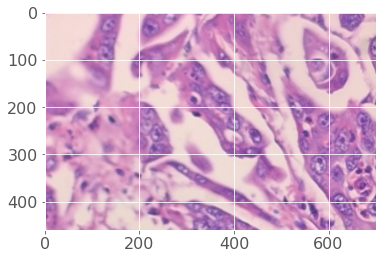

In [86]:
# now how to use transform
plt.imshow(im4d[0])

In [96]:
def my_crop_fn(im4d, dims):
    # want dims 
    h1 = dims[0]
    h2 = dims[1]
    w1= dims[2]
    w2 = dims[3]
    im4d_2 = im4d[:, h1:h2, w1:w2, :]
    return im4d_2
    
def center_square_crop(im4d):
    # Crops to get the center square of a rectangular image
    # note: only works for landscape shaped rectangle
    h = im4d.shape[1]  # 460
    w = im4d.shape[2]  # 700
    w1 = (w - h) // 2
    w2 = h + w1
    print ('want crop of dim {}:{}, {}:{}'.format(w1, w2, 0, h))
    im4d_c = my_crop_fn(im4d, tuple((w1, w2, 0, h)))
    return im4d_c

In [97]:
im4d_2 = my_crop_fn(im4d, tuple((0, 460, 120,580)))
im4d_2.shape

(4, 460, 460, 3)

In [98]:
im4d_c = center_sq (im4d)

want crop of dim 120:580, 0:460


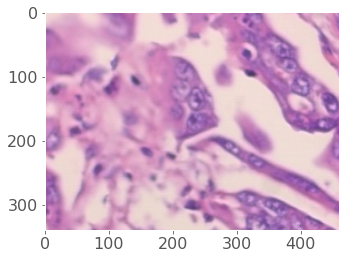

In [100]:
plt.imshow(im4d_c[0])  # center square crop :)
plt.grid(b=None)

In [ ]:
# PIL takes 4 tuple containing left, upper, right and lower coord
# Size of the image in pixels (size of orginal image) 
from PIL import image



# (This is not mandatory) 
width, height = im.size 
  
# Setting the points for cropped image 
left = 5
top = height / 4
right = 164
bottom = 3 * height / 4
  
# Cropped image of above dimension 
# (It will not change orginal image) 
im1 = im.crop((left, top, right, bottom)) 
  
# Shows the image in image viewer 
im1.show() 

In [ ]:

perform_image_transforms(ip)


In [ ]:
# Turns data into arrays
ip.vectorize()
ip.double_the_benigns()  # Evens out the classes

# Useful for EDA
img_dict = ip.get_one_of_each('M')
#plot_images(img_dict)

features = ip.features
target = ip.tumor_class_vector


print('features shape: {} '.format(features.shape))
print('shapes of train test input {} {}'.format(features.shape, target.shape))
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state=1)

    

In [ ]:
X_train[0]
# or get single image and do crop
img = X_train[:1]

img.imshow()
img2 = img.crop(0,0, 50, 50, copy=True)
img2.imshow()

In [ ]:
image_gen_train = preprocessing.image.ImageDataGenerator(rotation_range=20, 
                                                                #featurewise_center=True,
                                                                #rescale=1./255,
                                                                #featurewise_std_normalization=True,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                horizontal_flip=True, 
                                                                vertical_flip=True)

In [ ]:
image_gen_train.fit (X_train[:1], augment=True)  # 1st few images

In [ ]:
image_gen_train.get_random_transform(image_size)

In [ ]:
datagen = image_gen_train.flow(X_train, y_train)
datagen

In [ ]:
import io
img = np.array(datagen.next)
img.shape
type(datagen.next)
#io.imshow(datagen.next)

In [ ]:
image_gen_train = preprocessing.image.ImageDataGenerator(rotation_range=20, 
                                    #featurewise_center=True,
                                    #rescale=1./255,
                                    #featurewise_std_normalization=True,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    fill_mode='wrap')
# np_iter = preprocessing.image.NumpyArrayIterator(self.X_train, self.y_train, datagen)
# why both fit and flow?  fit gives you summary attrib's ex to apply ZCA Whitening
image_gen_train.fit(X_train, augment=True, rounds=5)

datagen = image_gen_train.flow(X_train, y_train)

In [ ]:

# iterator
start_img = X_train[:1]
aug_iter = image_gen_train.flow(start_img, batch_size=1)

# generate samples and plot
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

for i, ax in enumerate(axs.flatten()):

    # generate batch of images
    if i == 0:
        ax.imshow(X_train[0])
        ax.axis('off')
        ax.set_title='original'

    # convert to unsigned integers
    image = next(aug_iter)[0] #.astype('uint8'

    # plot image
    ax.imshow(image) # intepolation? 
    ax.axis('off')

plt.subplots_adjust (left=0.1, wspace=0.01)
    
    

In [ ]:
# This tricky bit makes one big image to show
'''
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
'''